<a href="https://colab.research.google.com/github/auto-d/mech-interp/blob/main/mi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

This is a toy project for exploring mechanistic interpretability methods. We train a small neural network to detect the presence of an ascii face in a string, then draw some conclusions about the network internals. The network is intentionally over-large, and the hope is we can elicit some sparsity that makes it easier to determine what is transpiring within different layers and ideally individual neurons.

## Dataset

Our challenge to the toy model will be to classify a text string as either containing an ASCII face or not.

Dataset generation and unicode escape sequence cleaning and padding out the data courtesy of GPT-5 (see https://chatgpt.com/c/690e24c8-a990-832d-9711-8f0cb77e94a3).

Define dictionary of cute faces for our dataset. We'll interleave these among random characters from the same charset to present a challenge to the model.

In [1]:
import random
import string

# Dictionary of horizontally-oriented ASCII faces (≈100 entries)
ascii_faces = {
    "happy": "(^_^)",
    "big_smile": "(^o^)",
    "winky": "(^_~)",
    "surprised": "(O_O)",
    "disappointed": "(>_<)",
    "cool": "(⌐■_■)",
    "thinking": "(¬_¬)",
    "angry": "(ಠ_ಠ)",
    "lenny": "( ͡° ͜ʖ ͡°)",
    "shrug": "¯\\_(ツ)_/¯",
    "smirk": "(¬‿¬)",
    "tired": "(‐_‐) zzz",
    "love": "(♥_♥)",
    "evil": "(>:) )",
    "shock": "(°o°)",
    "blush": "(^///^)",
    "party": "(ﾉ◕ヮ◕)ﾉ*:･ﾟ✧",
    "sunglasses": "(⌐■_■)",
    "eyeroll": "(¬_ಠ)",
    "confused": "(o_O)",
    "awkward": "(._.)",
    "victory": "＼(^o^)／",
    "yay": "(^_^)v",
    "hug": "(づ｡◕‿‿◕｡)づ",
    "disgust": "(ಠ_ಠ ┌)",
    "robot": "[¬º-°]¬",
    "bang": "(ノಠ益ಠ)ノ彡┻━┻",
    "wink_tongue": "(^<_<)",
    "side_eye": "(>_> )",
    "uhh": "(._. )",
    "cry": "(;_;)",
    "happy_tears": "(T_T)",
    "cool_alt": "(▀̿Ĺ̯▀̿ ̿)",
    "evil_grin": "(ʘ‿ʘ)",
    "ache": "(x_x)",
    "zombie": "(¬º-°)¬",
    "joker": "(☭_☭)",
    "pirate": "(☠_☠)",
    "robot2": "(⌐■⁠_⁠■)",
    "meh": "(-_-)",
    "sleepy": "(‐ ‐)zzz",
    "celebrate": "(ﾉ･ω･)ﾉﾞ",
    "chuckle": "(＾ω＾)",
    "grin": "(≧◡≦)",
    "evil_smile": "(¬‿¬ )",
    "sassy": "(¬_¬’)",
    "tongue": "(:P)",
    "groan": "(-｡-;)",
    "hug2": "(づ￣ ³￣)づ",
    "glasses": "(B^_^)B",
    "victory2": "(^‿^✿)",
    "cool3": "(⌐■_■)ﾉ",
    "wut": "(°_°)",
    "shock2": "(°◇°)",
    "angry2": "(ಠ益ಠ)",
    "eyeroll2": "(¬_¬)",
    "blush2": "(^///^)",
    "sad": "(T_T)",
    "confused2": "(O_o)",
    "surprised2": "(ʘ_ʘ)",
    "wow": "(°д°)",
    "smile2": "(^_−)☆",
    "silly": "(-:)",
    "yum": "(*≧ω≦)",
    "facepalm": "(－‸ლ)",
    "shush": "(☞ﾟヮﾟ)☞",
    "raise_hand": "o(￣▽￣)o",
    "highfive": "o/ (•‿•) \\o",
    "zany": "(۞‿۞)",
    "love2": "(♥‿♥)",
    "grimace": "(>_<;)",
    "smile3": "(◕‿◕)",
    "mischief": "( ۞‿۞)",
    "whistle": "(°▽°)ノ♪",
    "cheer": "(ﾉ^_^)ﾉ",
    "starstruck": "(✧ω✧)",
    "cool5": "(⌐▨_▨)",
    "ninja": "(ง •̀_•́)ง",
    "worry": "(・_・;)",
    "grumpy": "(－_－メ)",
    "geek": "(ಠ‿↼)",
}

Do some ChatGPT-powered cleaning of the handful of escaped characters that would deny us a char-> int mapping later.

In [2]:
# Setup for dataset generation sourced from ChatGPT-5 circa 9 Nov 2023

import re
import unicodedata
from pprint import pprint

# Characters we always strip (zero-widths, joiners, BOM, etc.)
ZERO_WIDTH = {
    '\u200b', '\u200c', '\u200d', '\u200e', '\u200f',  # ZW*, RTL/LTR marks
    '\u2060', '\u2061', '\u2062', '\u2063', '\u2064',  # word joiner, etc.
    '\ufeff',                                          # BOM
}
# Optional substitutions to normalize lookalikes (tweak to taste)
SUBS = {
    '—': '-',  # em dash -> hyphen
    '–': '-',  # en dash -> hyphen
    '－': '-',  # fullwidth hyphen-minus -> hyphen
    '·': '•',  # middle dot -> bullet (or flip if you prefer)
    '﹏': '_', # fullwidth low line alt -> underscore
}

# Regex for literal \uXXXX sequences (when strings are double-escaped)
_U_ESC_RE = re.compile(r'\\u([0-9a-fA-F]{4})')

def _decode_u_escapes(s: str) -> str:
    # Replace literal \uXXXX with the actual codepoint
    return _U_ESC_RE.sub(lambda m: chr(int(m.group(1), 16)), s)

def canonicalize(s: str, normalize_form="NFC") -> str:
    o = s
    # 1) turn any literal \uXXXX into real chars (if present)
    s = _decode_u_escapes(s)
    # 2) Unicode normalize (NFC keeps composed glyphs; NFKC is more aggressive)
    s = unicodedata.normalize(normalize_form, s)
    # 3) strip zero-width/control-ish characters
    s = ''.join(ch for ch in s if ch not in ZERO_WIDTH and not unicodedata.category(ch).startswith('C'))
    # 4) apply substitutions
    s = ''.join(SUBS.get(ch, ch) for ch in s)

    if o != s:
        print(f"Converted escaped sequence '{o}' to '{s}'")
    return s

def canonicalize_faces(dct: dict) -> dict:
    return {k: canonicalize(v) for k, v in dct.items()}

In [3]:
# Strip out escaped sequences and swap in something that won't blow up my vectorization
clean_faces = canonicalize_faces(ascii_faces)

# Grab the charset of the
face_charset = set()
for face in clean_faces.values():
    face_charset.update(face)
face_charset = ''.join(sorted(face_charset))

print("Face character set:", face_charset)  # helpful for debug

Converted escaped sequence '(⌐■⁠_⁠■)' to '(⌐■_■)'
Converted escaped sequence '(－‸ლ)' to '(-‸ლ)'
Converted escaped sequence '(－_－メ)' to '(-_-メ)'
Face character set:  ()*-./:;<>BOPT[\]^_ovxz~¬¯°³ºĹʖʘ̯̀́̿͜͡ωд۞ಠงლ‐’•‸‿↼−≦≧⌐━┌┻▀■▨▽◇◕◡☆☞☠☭♥♪✧✿づツノメヮ・彡益／＼＾｡･ﾉﾞﾟ￣


Define some ChatGPT-sourced routines for randomly sampling our cleaned face dict.

In [4]:
def get_random_face():
    """
    Return a random ASCII-face from the dictionary.

    Source: ChatGPT-5.1 circa 9 Nov 2023
    """
    return random.choice(list(clean_faces.values()))

def get_random_nonface(min_len=3, max_len=10):
    """
    Generate a random string of characters drawn only from face_charset,
    but arranged in a way that likely doesn’t look like a face.

    Source: ChatGPT-5.1 circa 9 Nov 2023
    """
    length = random.randint(min_len, max_len)
    return ''.join(random.choice(face_charset) for _ in range(length))

def sample_face(face_prob=0.5):
    """
    Sample either a face (positive) or a random non-face (negative).

    Source: ChatGPT-5.1 circa 9 Nov 2023
    """
    if random.random() < face_prob:
        return get_random_face(), True
    else:
        return get_random_nonface(), False

def generate_dataset(n_samples, face_prob=0.5):
    """
    Generate a list of (text, label) pairs.

    Source: ChatGPT-5.1 circa 9 Nov 2023
    """
    return [ sample_face(face_prob) for _ in range(n_samples) ]


Now randomly select a few faces and non-faces along with their label to validate the strategy. Then emit a dataset-worthy array of same.

In [5]:
# Test our dataset generator
for _ in range(10):
    seq, label = sample_face(face_prob=0.5)
    print(f"{seq} => {'FACE' if label else 'NON-FACE'}")

̀↼･▀┻ => NON-FACE
(O_O) => FACE
д>◇━́͜＼ => NON-FACE
(-_-メ) => FACE
＼(^o^)／ => FACE
́ლO => NON-FACE
(^_~) => FACE
(:<ʖ => NON-FACE
＼:▀￣ => NON-FACE
☆:ﾞ)益‿\・• => NON-FACE


In [6]:
# Generate a dataset of faces and non-faces
seqs = []
labels = []
for _ in range(1000):
  seq, label = sample_face(face_prob=0.5)
  seqs.append(seq)
  labels.append(label)

Finally, we need to get to a fixed-width for our input vector to the model we'll build. Sprinkle some GPT-5 sauce to define functions that map our characters into a relatively compact integer space (avoids super sparse values we'd otherwise get if we used the unicode value) and emit a padded variant of our dataset (fixed sequence length).

In [7]:
def build_global_char_mapping(all_characters):
    """
    Build integer mappings for every unique Unicode character in the dataset.

    Parameters:
        all_characters (Iterable[str]): A set or list of all unique characters
                                        you expect to encounter (faces + non-faces).
    Returns:
        tuple(dict, dict): (char_to_int, int_to_char)

    Source: ChatGPT-5.1 circa 9 Nov 2023
    """
    # Sort for deterministic ordering (important for reproducibility)
    sorted_chars = sorted(all_characters)

    # Assign a unique integer ID to each character
    char_to_int = {ch: idx for idx, ch in enumerate(sorted_chars)}
    int_to_char = {idx: ch for ch, idx in char_to_int.items()}

    return char_to_int, int_to_char

def encode_strings(strings, char2int):
    """
    Convert a list of strings into integer-based representations
    using the provided char2int mapping.
    Unknown characters are ignored or mapped to 0 if desired.
    Returns a list of lists of integers.

    Source: ChatGPT-5.1 circa 9 Nov 2023
    """
    encoded = []
    for s in strings:
        encoded.append([char2int.get(ch, 0) for ch in s])
    return encoded

def decode_strings(encoded, int2char):
    """
    Decode our strings
    """

    decoded = []
    for a in encoded:
        decoded.append("".join([int2char.get(tok, "?") for tok in a]))
    return decoded

def random_pad_sequences(encoded_strings, pad_value=0):
    """
    Randomly pad each integer sequence (left or right) so all have the same length.
    pad_value is used for padding.
    Returns a new list of equal-length sequences.

    Source: ChatGPT-5.1 circa 9 Nov 2023
    """
    # 1. Determine max length
    max_len = max(len(seq) for seq in encoded_strings)
    padded = []

    for seq in encoded_strings:
        pad_len = max_len - len(seq)
        if pad_len == 0:
            padded.append(seq)
            continue

        # Randomly choose left or right padding
        if random.random() < 0.5:
            # left pad
            new_seq = [pad_value] * pad_len + seq
        else:
            # right pad
            new_seq = seq + [pad_value] * pad_len

        padded.append(new_seq)

    return padded, max_len

Build a mapping and test the encoding to see a string and its integer value:

In [8]:
char2int, int2char = build_global_char_mapping(face_charset)

test = seqs[1]
print(test)
encode_strings([test], char2int)

(ﾉ^_^)ﾉ


[[1, 86, 18, 19, 18, 2, 86]]

Now we can properly encode our strings and pad the result randomly to achieve fixed-width and positional diversity. We'll scale and recast these as floats to prepare for modeling.

In [9]:
encoded = encode_strings(seqs, char2int)
padded, seq_len = random_pad_sequences(encoded)

In [10]:
import torch

vocab_length = len(char2int)
X = torch.tensor(padded, dtype=torch.int32)
y = torch.tensor(labels, dtype=torch.float32)

In [11]:
X.shape

torch.Size([1000, 12])

In [12]:
X[0:5]

tensor([[ 0,  0,  0,  0,  0,  0,  0,  1, 25, 19, 25,  2],
        [ 0,  0,  0,  0,  0,  1, 86, 18, 19, 18,  2, 86],
        [ 0,  0,  0,  0,  0,  0,  0,  1, 25, 49, 25,  2],
        [34, 67, 55, 82, 72, 84, 79, 25, 72,  0,  0,  0],
        [ 0,  0, 41, 66, 77, 65, 83,  6, 49, 82, 28, 77]], dtype=torch.int32)

In [13]:
y[0:5]

tensor([1., 1., 1., 0., 0.])

## Model Architecture

We now need to build a model that will accept our weird sequence and try to classify it. We opt for a wickedly pared down variant of the transformer.

In [14]:
import math
import numpy
import torch.nn as nn
from torch.nn import functional as F

Define the architecture, which is a single attention block on top of some fully connected layers.

In [15]:
class SelfAttention(nn.Module):
    """
    A toy torch module for self attention. Informed by Andrej Karpathy's mingpt project
    (https://github.com/karpathy/minGPT) and a slightly embarassing conversation with
    ChatGPT-5 (https://chatgpt.com/share/690e21fa-e718-8004-860a-45109a95c291)
    """

    def __init__(self, n_dim=10, scale=False):
        """
        Input dimensions are typically sharded across heads in multi-head attention.
        We are aiming for simplicity and avoid this, using just a single 'head' with
        the full input dimension.
        """
        super().__init__()
        self.Q = nn.Linear(n_dim, n_dim)
        self.K = nn.Linear(n_dim, n_dim)
        self.V = nn.Linear(n_dim, n_dim)

        self.n_dim = n_dim
        self.scale = scale

    def forward(self, x):
        """
        We accept input in the shape of seq length, model dimension.

        Note we don't need any linear layers as output because we're only using a single
        attention head. If we had more, we would need to map our heads back into the d_model
        space with a linear layer.
        """

        # Project our input into the query space (i.e. multiply by the query weights),
        # do the same for the key vectors. Then apply our similarity operation (dot product
        # by way of matmul) to yield an attention tensor.
        q = self.Q(x)
        k = self.K(x)
        attn = torch.matmul(q, k.transpose(-2,-1))

        # We optionally scale our attention values down to avoid them blasting off and saturating
        # the softmax function (thereby destroying gradients during backprop). For tiny models,
        # this is probably not an issue and so we allow omission to simplify the model.
        if self.scale:
            attn = attn / math.sqrt(self.n_dim)

        # Now normalize our logits with softmax so we can scale the value vector based on the
        # attention we are learning to pay to each respective token
        attn = F.softmax(attn, dim=-1)

        v = self.V(x)

        out = torch.matmul(attn, v)

        return out


In [16]:
class FaceClassifier(nn.Module):
  """
  Dramatically oversized model to detect an ascii face in a string. However the sparsity it
  probably encourages works for our introspection effort (maybe we can find some features associated
  with specific faces)
  """

  def __init__(self, vocab_size, seq_len, n_dim):
      """
      Define a model that accepts a sequence and predicts whether it
      contains a face. We don't support a batch dimension to simplify the matmuls
      etc.
      """
      super().__init__()

      # Give the model a scratch pad, project each character into a richer space to learn some features
      self.embedder = nn.Embedding(vocab_size, n_dim)
      self.attn = SelfAttention(n_dim=n_dim, scale=True)
      self.fc = nn.Linear(seq_len * n_dim, 1)
      self.sigmoid = nn.Sigmoid()

  def forward(self, X):
      """
      Do a forward pass through the network, applying attention and emitting a class probability.
      We accept a sequence of single values (representing the respective character), of
      shape (seq, 1).
      """
      # Learn a multidimensional (n_dim size) representation of the input characters, one for each character
      # (n_seq, 1) -> (n_seq, n_dim)
      X = self.embedder(X)

      # (n_seq, n_dim) -> (n_seq, n_dim)
      X = self.attn(X)

      # (n_seq * n_dim) -> (1)
      X = self.fc(torch.flatten(X))

      # (1) -> [0, 1]
      X = self.sigmoid(X)

      return X

Set up our training loop, notably caching key weights at each epoch for downstream inspection.

In [17]:
import numpy as np

def validate(model, X, y):
    """
    Hasty validation of model performance against furnished data
    """
    model.eval()
    with torch.no_grad():
        preds = []
        for x, y_ in zip(X,y):
            pred = model(x)
            preds.append(pred)

        preds = torch.tensor(preds)
        mae = torch.abs(preds - y.numpy()).mean().item()

    return mae

In [18]:
def train(model, X_train, y_train, X_test, y_test, epochs=100):
    """
    Train the face classifier
    """

    # Use a fancy optimizer to help us converge, larger learning rates here result in a failure to
    # stabilize at a low loss
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

    # Binary cross-entropy loss calculator for our binary classification task
    loss_fn = nn.BCELoss()

    train_loss = []
    val_loss = []

    e_weights = []
    q_weights = []
    f_weights = []

    for epoch in range(epochs):

        # Training mode, ensure gradients are tracked, etc.
        model.train()

        epoch_loss = []

        # Snoop our embedding layers for a single token/character (token 1) as it evolves
        e_weights.append(model.embedder.weight.detach().clone().numpy())

        for x, y in zip(X_train, y_train):

            # Forward pass
            out = model(x)

            # Compute loss
            loss = loss_fn(out, y.ravel())

            # Backprop
            optimizer.zero_grad()

            # Calculate gradients
            loss.backward()

            # Apply those gradients to inch, bound, fly towards lower loss
            optimizer.step()

            epoch_loss.append(loss.item())

        # Also track query weights for the lone attention block
        q_weights.append(model.attn.Q.weight.detach().clone().numpy())
        f_weights.append(model.fc.weight.detach().clone().numpy())

        train_loss.append(np.mean(epoch_loss))
        val_loss.append(validate(model, X_test, y_test))
        print(f"Epoch loss: {train_loss[-1]:.7f} Validation loss: {val_loss[-1]:.7f}")

    return train_loss, val_loss, e_weights, q_weights, f_weights


## Modeling

Now let's split up our data and train the model!

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [20]:
model = FaceClassifier(vocab_size=len(face_charset), seq_len=seq_len, n_dim=4)

It's important to note we smuggled in some traces during training. For every epoch we record the full weight matrices of our embedding layer, the attention block's query layer and our fully-connected layer that maps all the output of the attention block for every member in the sequence to a single logit.  This enable us to inspect the parameter evolution over time.  

In [21]:
train_loss, val_loss, e_weights, q_weights, f_weights = train(model, X_train, y_train, X_test, y_test, epochs=15)

/tmp/ipython-input-2009099114.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mae = torch.abs(preds - y.numpy()).mean().item()


Epoch loss: 0.3975095 Validation loss: 0.0788246
Epoch loss: 0.0735843 Validation loss: 0.0449739
Epoch loss: 0.0378160 Validation loss: 0.0325896
Epoch loss: 0.0191711 Validation loss: 0.0239246
Epoch loss: 0.0108485 Validation loss: 0.0185097
Epoch loss: 0.0049203 Validation loss: 0.0141240
Epoch loss: 0.0012879 Validation loss: 0.0122009
Epoch loss: 0.0006388 Validation loss: 0.0111290
Epoch loss: 0.0003565 Validation loss: 0.0105417
Epoch loss: 0.0002069 Validation loss: 0.0102006
Epoch loss: 0.0001233 Validation loss: 0.0099960
Epoch loss: 0.0000749 Validation loss: 0.0098737
Epoch loss: 0.0000461 Validation loss: 0.0098037
Epoch loss: 0.0000287 Validation loss: 0.0097683
Epoch loss: 0.0000181 Validation loss: 0.0097562


Now, inspect our loss curves.

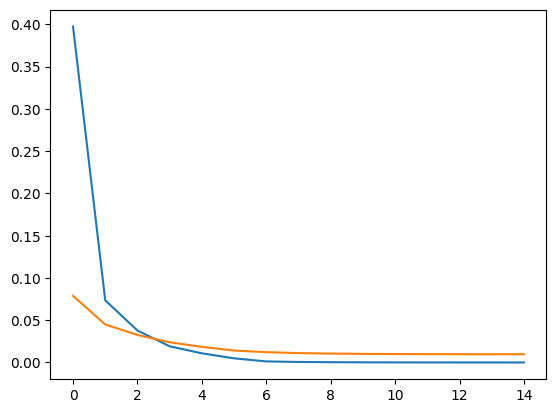

In [22]:
from matplotlib import pyplot as plt

plt.plot(train_loss)
plt.plot(val_loss)

Loss looks great, and the validation improvement levels out around 10-12 epochs, depending on the run. We'll hold there roughly and use the result as our model. Note the number of epochs required to plateau our loss values is highly dependent on weight initialization here.

## Exploration

We'll start with a sanity check on our face strings to confirm the predictions map to our interpretation of ASCII faces.

In [23]:
decoded = decode_strings(X_test[0:15].numpy(), int2char)
model.eval()
for d,x in zip(decoded, X_test[0:15]):
    pred = model(x)
    print(f"{d} -> face {'detected' if pred > 0.5 else 'NOT DETECTED'}")

       (-‸ლ) -> face detected
(¬_ಠ)        -> face detected
       ̿ ↼・‿ -> face NOT DETECTED
       (۞‿۞) -> face detected
   -(＾━]┻‿┻^ -> face NOT DETECTED
        メ‸Tʖ -> face NOT DETECTED
     (^///^) -> face detected
  v■͡’Oʖ▀ʖ)彡 -> face NOT DETECTED
      (>_<;) -> face detected
   ┌ツ¯^☭́☭・━ -> face NOT DETECTED
  ́♥̀<P☠: 彡( -> face NOT DETECTED
ノ͡*_✧‸◡益づ    -> face NOT DETECTED
・ツ/♥         -> face NOT DETECTED
¬メ<￣         -> face NOT DETECTED
  (ง •̀_•́)ง -> face detected


Perfect, our face detector is firing on all (most) cylinders.  Here though it may occur to the reader as it is now occurring to the author that we've built a very complicated parenthesis matcher. Most faces in our face dataset have matching left and right parenthesis which the network will have certainly learned to exploit! Ah well, this is a *toy* model I suppose.

We'll start by inspecting our model geometry again.

In [24]:
model

FaceClassifier(
  (embedder): Embedding(90, 4)
  (attn): SelfAttention(
    (Q): Linear(in_features=4, out_features=4, bias=True)
    (K): Linear(in_features=4, out_features=4, bias=True)
    (V): Linear(in_features=4, out_features=4, bias=True)
  )
  (fc): Linear(in_features=48, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Let's peak at the learned embeddings, which we incorporated to give the model some additional dimensionality to explore more robust representations of our characters. Recall that we emitted a trace of these weights across every epoch during training.  We have 15 epochs, 90 characters in our character set, and variable embedding dimensions for each. Hence the below shape:

In [25]:
e = numpy.array(e_weights)
e.shape

(15, 90, 4)

We have this intuition, which may or may not be well founded, that the more interesting characters to the model will require more tinkering of the higher-dimensional representation throughout training. We'll test this hypothesis by looking at the standard deviation of weights across epochs for each character and report the most volatile.

In [44]:
stdevs = [np.std(e[:,i,0]) + np.std(e[:,i,1]) + np.std(e[:,i,2]) for i in range(0, len(face_charset))]

k = 5
top_k = []
stdevs2 = stdevs.copy()
for i in range(1,k):
    mx = np.argmax(stdevs2)
    top_k.append(stdevs2[mx])
    stdevs2.pop(mx)

print(f"Top std deviations:")
for i, char in enumerate(face_charset):
    if stdevs[i] in top_k:
        print(f"Char index {i}: {char} embedding std dev @ {stdevs[i]:.2f}")


Top std deviations:
Char index 1: ( embedding std dev @ 0.73
Char index 2: ) embedding std dev @ 0.72
Char index 15: [ embedding std dev @ 0.61
Char index 29: º embedding std dev @ 0.66


In testing across multiple runs, the hunch aligns with the weight manipulations the network introduced to tune the left and right parenthesis embeddings. Your mileage mary vary on subsequent runs. Let's look at how the prominent left parenthesis evolved over training and compare it with a not-very-facelike character, the 'z''.

In [27]:
face_charset

' ()*-./:;<>BOPT[\\]^_ovxz~¬¯°³ºĹʖʘ̯̀́̿͜͡ωд۞ಠงლ‐’•‸‿↼−≦≧⌐━┌┻▀■▨▽◇◕◡☆☞☠☭♥♪✧✿づツノメヮ・彡益／＼＾｡･ﾉﾞﾟ￣'

In [28]:
lparen = 1
z = 23

In [29]:
import seaborn as sns

Here we see the evolution of the left parenthesis embeddings weights across all epochs.

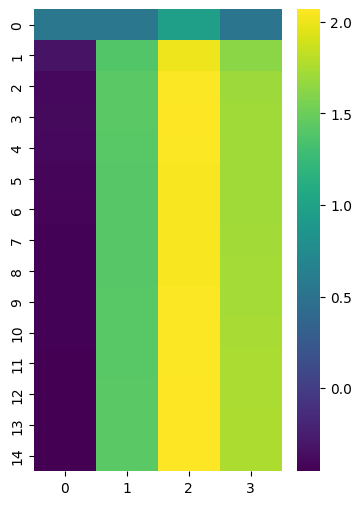

In [30]:
plt.figure(figsize=(4,6))
_ = sns.heatmap(e[:,lparen,:], cmap='viridis')

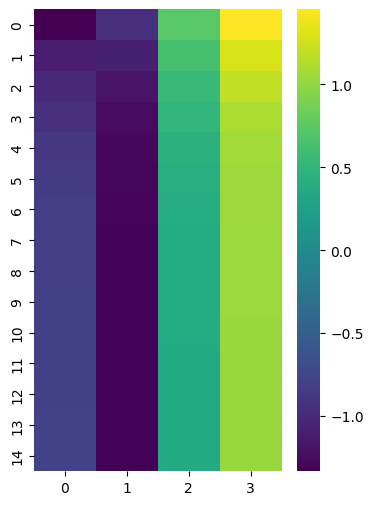

In [31]:
plt.figure(figsize=(4,6))
_ = sns.heatmap(e[:,z,:], cmap='viridis')

Even with this simple example it's evident (again, depends on the training run) that our stdev idea is pretty flawed. Not only do we discount the intervening changes between epochs, but the model is just as likely to have to suppress activations of irrelevant characters as it is to amplify characters that correlate with faces in various positions. The heatmap changes seem to be very depending on random initialization.

We'll move on to the query weights in our lone attention head.

In [32]:
q = numpy.array(q_weights)
q.shape

(15, 4, 4)

Here we see the Q matrix on initialization, this should be pure randomness.

<Axes: >

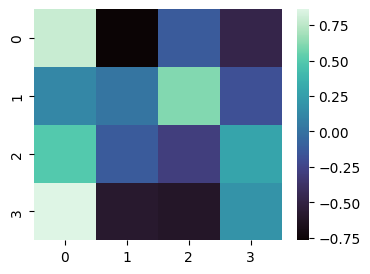

In [33]:
plt.figure(figsize=(4,3))
sns.heatmap(q[0,:,:], cmap='mako')

At the end of the last epoch, our Q matrix has evolved to the below, which candidly looks just as random. I guess that's why we care about mechanistic interpretability (perusal of the weights doesn't yield much insight).

<Axes: >

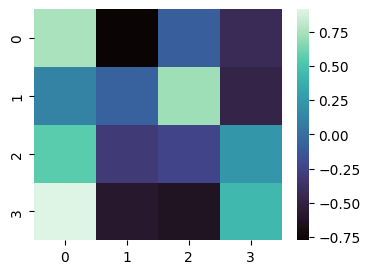

In [34]:
plt.figure(figsize=(4,3))
sns.heatmap(q[14,:,:], cmap='mako')

Attempt to zeroize each of the weights in the query matrix and assess impact on error rate.

In [35]:
og_Q = model.attn.Q.weight.clone()

print(f"Q weight baseline MAE: {validate(model, X_test, y_test):.3f}")

with torch.no_grad():
    for i in range(0, og_Q.shape[0]):
        for j in range(0, og_Q.shape[1]):
            model.attn.Q.weight[i][j] = 0
            print(f"Q weight {i},{j} ablation MAE: {validate(model, X_test, y_test):.3f}")
            model.attn.Q.weight[i][j] = og_Q[i][j]

/tmp/ipython-input-2009099114.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mae = torch.abs(preds - y.numpy()).mean().item()


Q weight baseline MAE: 0.010
Q weight 0,0 ablation MAE: 0.012
Q weight 0,1 ablation MAE: 0.010
Q weight 0,2 ablation MAE: 0.010
Q weight 0,3 ablation MAE: 0.010
Q weight 1,0 ablation MAE: 0.010
Q weight 1,1 ablation MAE: 0.010
Q weight 1,2 ablation MAE: 0.011
Q weight 1,3 ablation MAE: 0.010
Q weight 2,0 ablation MAE: 0.010
Q weight 2,1 ablation MAE: 0.010
Q weight 2,2 ablation MAE: 0.010
Q weight 2,3 ablation MAE: 0.010
Q weight 3,0 ablation MAE: 0.013
Q weight 3,1 ablation MAE: 0.009
Q weight 3,2 ablation MAE: 0.009
Q weight 3,3 ablation MAE: 0.009


We can see most ablations here do not cause an appreciable decrease in performance, though the `Q[0,2]` neuron when zeroed out during one run caused the MAE to virtually double.

Finally, let's look at the fully-connected layer that links the attention head to the logic that powers our probabilities. Here we weights in the shape of (epochs, output, input).

In [36]:
f = numpy.array(f_weights)
f.shape

(15, 1, 48)

<Axes: >

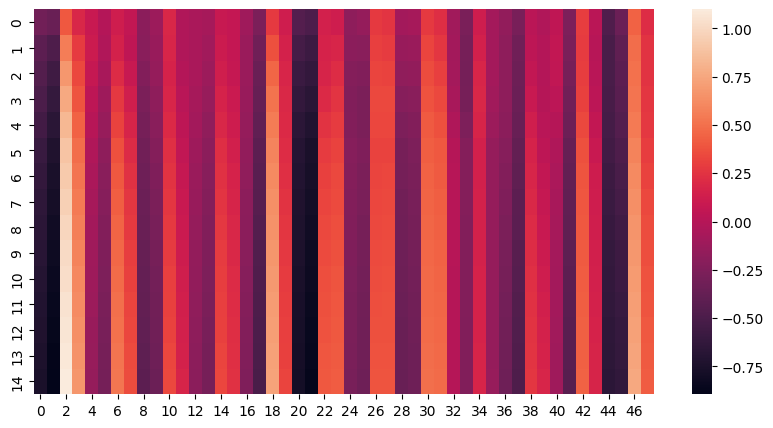

In [37]:
plt.figure(figsize=(10,5))
sns.heatmap(f[:,0,:])

We see a clear evolution of these weights from a sort of murky distribution to a much more stark and, eh, opinionated view of the role of each neuron in the output.

<Axes: >

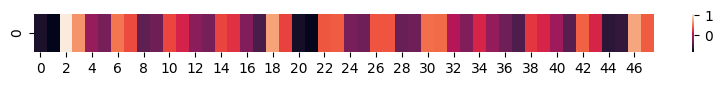

In [38]:
plt.figure(figsize=(10,0.5))
sns.heatmap(f[-2:-1,0,:])

Now let's manipulate each of the fully-connected weights and see what impact it has on the output error, as with the Q matrix.  

In [54]:
base_mae = validate(model, X_test, y_test)
print(f"Baseline model MAE: {base_mae:.3f}\n")

Baseline model MAE: 0.010



/tmp/ipython-input-2009099114.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mae = torch.abs(preds - y.numpy()).mean().item()


In [47]:
og_weights = model.fc.weight.clone()

maes = []
with torch.no_grad():
    for i, weight in enumerate(model.fc.weight[0]):
        model.fc.weight[0][i] = -model.fc.weight[0][i]
        maes.append(validate(model, X_test, y_test))
        model.fc.weight[0][i] = og_weights[0][i]

/tmp/ipython-input-2009099114.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mae = torch.abs(preds - y.numpy()).mean().item()


Text(0.5, 1.0, 'MAE Impact by Ablated Neuron in FC Layer\nBaseline MAE shown in red')

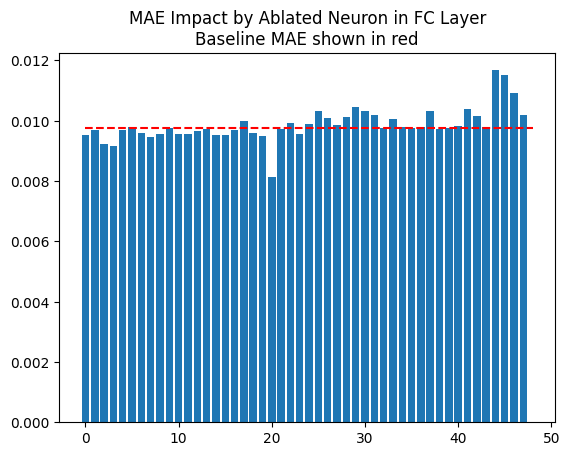

In [57]:
plt.bar(height=maes, x=range(0, len(maes)))
plt.hlines(y=base_mae, xmin=0, xmax=len(maes), linestyles='dashed', colors='red') # Syntax for hline assisted by chatgpt-5.1
plt.title("MAE Impact by Ablated Neuron in FC Layer\nBaseline MAE shown in red")

Somewhat surprisingly, there is rarely evidence of individual neuron ablations impacting output quality on the test set!

## Explanation

The model is overly complex for its task, and to boot, the network's task was easier than I suspected due to the prominence of the left and right parenthesis in the positive class examples. It wasn't obvious at the outset would be found in most faces.

During many training runs the network displays a resilience that was unanticipated. Occasionally FC neurons appear that have resulted in doubling the error on the test set when ablated, but these do not rematerialize during subsequent runs.

It isn't obvious what motivates the network to repeatedly develop a resilience to ablation interventions, and the aspiration to achieve sparsity was clearly countered by this tendency.

Perhaps the random initialization of weights herds the model toward the lower-energy solution. That is, is subtle changes to those random initializations that achieve the goal without requiring large swings or trying to hold activations near zero for unneeded neurons. This is almost certainly where we reach for regularization to encourage the reduction of strong 'players' in the network. That said, this is a place to pick up and learn more about, as the tendency to broadcast logic throughout the network seems counterintuitive given the simplicity of the problem.

## Reflection

The original thought for making the network overly large was to encourage sparsity. However instead of "picking" individual neurons in the FC layer to activate on one or more characters, the network spreads its logic over many neurons, defying this style of minor intervention.

Overall this effort against a toy model highlights the complexity associated with interpretability of real deep-learning models with parameter counts that are increasing by the day.